# Assignment : Policy Gradient

Philip Paquette and Stéphanie Larocque

In [0]:
! pip install -q gym
! pip install -q matplotlib
! pip install -q tensorflow
import numpy as np
import itertools

In [0]:
import gym
from matplotlib import pyplot as plt
import tensorflow as tf


class Agent(object):
    """ The learning agent """

    def __init__(self, env_name, gamma=0.95,
                 use_policy_trace=True, policy_alpha=0.03, policy_lambda=0.9,
                 use_critic_trace=True, critic_alpha=0.005, critic_lambda=0.9):
        """ Constructor """
        tf.reset_default_graph()
        self.gamma = gamma
        self.use_policy_trace = use_policy_trace
        self.policy_alpha = policy_alpha
        self.policy_lambda = policy_lambda
        self.use_critic_trace = use_critic_trace
        self.critic_alpha = critic_alpha
        self.critic_lambda = critic_lambda

        # Inspecting env
        env = gym.make(env_name)
        self.nb_actions = env.action_space.n
        self.obs_space_shape = list(env.observation_space.shape)

        # Model
        self.placeholders = {'state': tf.placeholder(tf.float32, shape=[1] + self.obs_space_shape),
                             'action': tf.placeholder(tf.int32, shape=[1]),
                             'target': tf.placeholder(tf.float32, shape=[1]),
                             'old_value': tf.placeholder(tf.float32, shape=[1])}
        self.outputs = {}
        self.ops = {}
        self.I = tf.get_variable('I', dtype=tf.float32, shape=(), trainable=False, initializer=tf.ones_initializer)
        self.build_model()
        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())

    def build_model(self):
        """ Builds the model """
        state = self.placeholders['state']
        action = self.placeholders['action']
        target = self.placeholders['target']
        old_value = self.placeholders['old_value']
        delta = target - old_value

        # Policy network
        with tf.variable_scope('policy'):
            logits = tf.layers.dense(state, self.nb_actions, activation=None)
            probs = tf.nn.softmax(logits)
            log_probs = tf.log(probs)
            log_prob_chosen_action = tf.gather(log_probs, action, axis=1)
            self.outputs['sampled_action'] = tf.multinomial(log_probs, num_samples=1)

        # Critic network
        with tf.variable_scope('critic'):
            value = tf.layers.dense(state, 1, activation=None)
            self.outputs['value'] = value

        # Gradients
        with tf.variable_scope('gradients'):
            policy_opt = tf.train.AdamOptimizer(self.policy_alpha)
            critic_opt = tf.train.AdamOptimizer(self.critic_alpha)
            policy_vars = tf.trainable_variables('policy')
            critic_vars = tf.trainable_variables('critic')
            policy_grads = tf.gradients(log_prob_chosen_action, policy_vars)
            critic_grads = tf.gradients(value, critic_vars)

        # Traces
        policy_traces = [1] * len(policy_vars)
        critic_traces = [1] * len(critic_vars)
        with tf.variable_scope('traces'):
            if self.use_policy_trace:
                policy_traces = [tf.get_variable(var.name.split(':')[0],
                                                 shape=var.shape,
                                                 dtype=var.dtype,
                                                 trainable=False,
                                                 initializer=tf.zeros_initializer) for var in tf.trainable_variables('policy')]
            if self.use_critic_trace:
                critic_traces = [tf.get_variable(var.name.split(':')[0],
                                                 shape=var.shape,
                                                 dtype=var.dtype,
                                                 trainable=False,
                                                 initializer=tf.zeros_initializer) for var in tf.trainable_variables('critic')]

        # Recalculating policy gradients
        policy_ops = []
        new_policy_grads = []
        for var, grad, trace in zip(*[policy_vars, policy_grads, policy_traces]):
            if self.use_policy_trace:
                updated_trace = self.gamma * self.policy_lambda * trace + self.I * grad
                policy_ops += [tf.assign(trace, updated_trace)]
                new_policy_grads += [-delta * updated_trace]
            else:
                new_policy_grads += [-delta * self.I * grad]
        policy_ops += [policy_opt.apply_gradients(zip(new_policy_grads, policy_vars))]

        # Recalculating critic gradients
        critic_ops = []
        new_critic_grads = []
        for var, grad, trace in zip(*[critic_vars, critic_grads, critic_traces]):
            if self.use_critic_trace:
                updated_trace = self.gamma * self.critic_lambda * trace + self.I * grad
                critic_ops += [tf.assign(trace, updated_trace)]
                new_critic_grads += [-delta * updated_trace]
            else:
                new_critic_grads += [-delta * self.I * grad]
        critic_ops += [critic_opt.apply_gradients(zip(new_critic_grads, critic_vars))]

        # Ops
        self.ops['reset_traces'] = tf.group(tf.variables_initializer([self.I]),
                                            tf.variables_initializer(policy_traces) if self.use_policy_trace else tf.no_op(),
                                            tf.variables_initializer(critic_traces) if self.use_critic_trace else tf.no_op())
        self.ops['critic_ops'] = tf.group(critic_ops)
        self.ops['policy_ops'] = tf.group(policy_ops)
        self.ops['decay_I'] = tf.assign(self.I, self.gamma * self.I)

    def start_episode(self):
        """ Resets the eligibility traces when starting a new episode """
        self.session.run(self.ops['reset_traces'])

    def get_action(self, state):
        """ Returns the action to play in the given state """
        return min(self.nb_actions - 1,
                   self.session.run(self.outputs['sampled_action'], feed_dict={self.placeholders['state']: [state]})[0][0])

    def get_value(self, state):
        """ Returns the value of the given state """
        return self.session.run(self.outputs['value'], feed_dict={self.placeholders['state']: [state]})[0][0]

    def learn(self, state, action, reward, next_state, is_done):
        """ Learns from a transition """
        state_value = self.get_value(state)
        next_state_value = self.get_value(next_state) if not is_done else 0.
        target = reward + self.gamma * next_state_value
        old_value = state_value

        # Feed dict
        feed_dict = {self.placeholders['state']: [state],
                     self.placeholders['action']: [action],
                     self.placeholders['target']: [target],
                     self.placeholders['old_value']: [old_value]}

        # Updating
        self.session.run(self.ops['critic_ops'], feed_dict=feed_dict)
        self.session.run(self.ops['policy_ops'], feed_dict=feed_dict)
        self.session.run(self.ops['decay_I'], feed_dict=feed_dict)

def train_agent(agent, env_name, nb_episodes, plot_results = True):
    """ Trains an agent on an env for a certain number of episodes """
    env = gym.make(env_name)
    rewards = []

    for episode_ix in range(nb_episodes):
        episode_reward = 0.
        agent.start_episode()
        done = False
        env_state = env.reset()

        while not done:
            env_action = agent.get_action(env_state)
            env_next_state, env_reward, done, _ = env.step(env_action)
            episode_reward += env_reward

            # Adding a negative reward if we don't reach the max number of steps
            if done and episode_reward < env._max_episode_steps - 10:
                env_reward -= 0.5 * env._max_episode_steps

            agent.learn(env_state, env_action, env_reward, env_next_state, done)
            env_state = env_next_state

        if (episode_ix + 1) % 100 == 0:
            print('.',)
        elif (episode_ix + 1) % 10 == 0:
            print('.', end='')
        rewards += [episode_reward]

    if plot_results :
      # Plotting rewards

      plt.title("Reward received for each time step")
      plt.plot(rewards)
      plt.show()

      plt.title("Average reward for the last 15 episodes")
      plt.plot([np.mean(rewards[ix - 15: ix]) for ix in range(15, len(rewards))])
      plt.show()
    
    return rewards

In [0]:
def plot_results(rewards, smoothing_factor = 15):
  for r in rewards:
    plt.plot(r)
  plt.show()
 
  for r in rewards:
    plt.plot([np.mean(r[ix - 15: ix]) for ix in range(15, len(r))])
  plt.show()

In [0]:
# Hyperparameters

gamma = 0.95
policy_alpha = 0.01
critic_alpha = 0.01
policy_lambda = 0.99
critic_lambda = 0.99

Result on both traces
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........


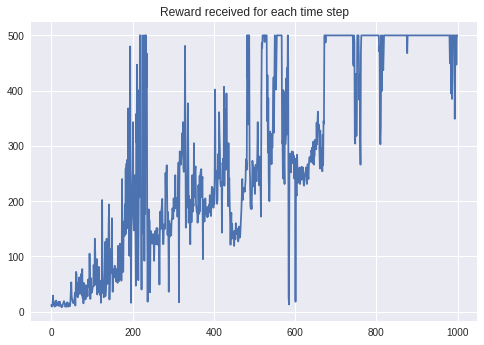

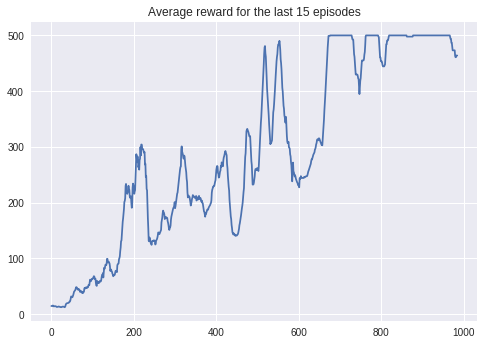

In [6]:
# Both traces

print("\n------------------------------------------------------")
print("            Results with both traces")
print("------------------------------------------------------")

ENV_NAME = 'CartPole-v1'
NB_EPISODES = 1000
agent = Agent(ENV_NAME, gamma = gamma,
              policy_alpha= policy_alpha, critic_alpha= critic_alpha, 
              policy_lambda = policy_lambda, critic_lambda = critic_lambda,
              use_policy_trace=True, use_critic_trace=True)
r = train_agent(agent, ENV_NAME, NB_EPISODES)

Results with trace only on the critic, not the actor
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........


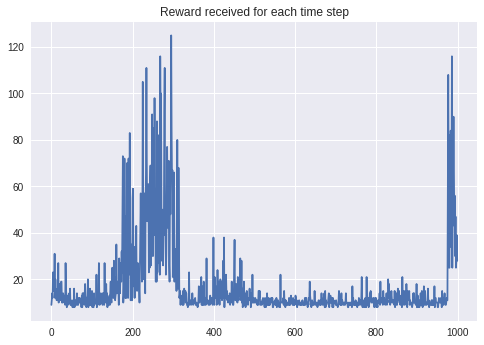

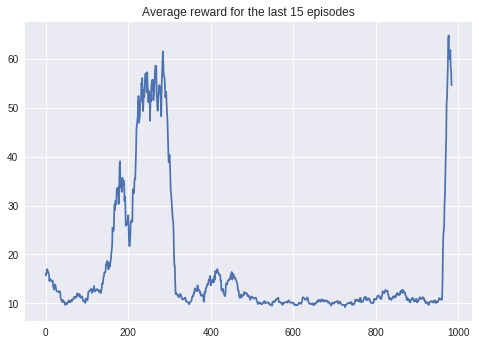

In [7]:
# Trace only on the critic (no trace on the actor)
print("\n------------------------------------------------------")
print("       Results with trace only on the critic, not the actor")
print("------------------------------------------------------")

ENV_NAME = 'CartPole-v1'
NB_EPISODES = 1000
agent = Agent(ENV_NAME, gamma = gamma,
              policy_alpha= policy_alpha, critic_alpha= critic_alpha, 
              policy_lambda = policy_lambda, critic_lambda = critic_lambda,
              use_policy_trace=False, use_critic_trace=True)
r = train_agent(agent, ENV_NAME, NB_EPISODES)

Results without any trace
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........


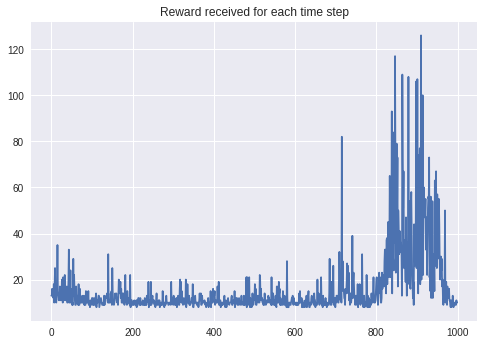

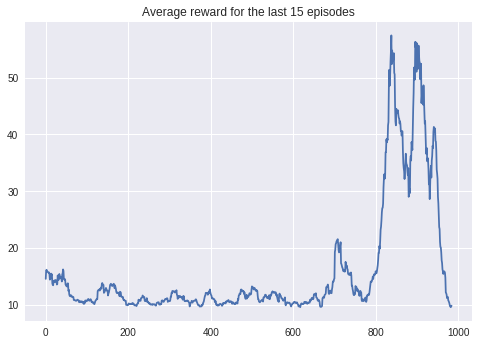

In [8]:
# No trace at all
print("\n------------------------------------------------------")
print("            Results without any trace")
print("------------------------------------------------------")

ENV_NAME = 'CartPole-v1'
NB_EPISODES = 1000
agent = Agent(ENV_NAME, gamma = gamma,
              policy_alpha= policy_alpha, critic_alpha= critic_alpha, 
              policy_lambda = policy_lambda, critic_lambda = critic_lambda,
              use_policy_trace=False, use_critic_trace=False)
r = train_agent(agent, ENV_NAME, NB_EPISODES)

In [26]:
print("\n------------------------------------------------------")
print("            Effect of gamma (with both traces)" )
print("------------------------------------------------------")

all_gamma_rewards = []
gammas = [0.9, 0.95, 0.99, 1.]

ENV_NAME = 'CartPole-v1'
NB_EPISODES = 1000
for g in gammas:
  agent = Agent(ENV_NAME, gamma = g,
                policy_alpha= policy_alpha, critic_alpha= critic_alpha, 
                policy_lambda = policy_lambda, critic_lambda = critic_lambda,
                use_policy_trace=True, use_critic_trace=True)
  r = train_agent(agent, ENV_NAME, NB_EPISODES, plot_results=False)
  
  all_gamma_rewards.append(r)


------------------------------------------------------
            Effect of gamma (with both traces)
------------------------------------------------------
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
..........
..........
..........
..........
..........
..........
..........
......

....
..........
..........
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........


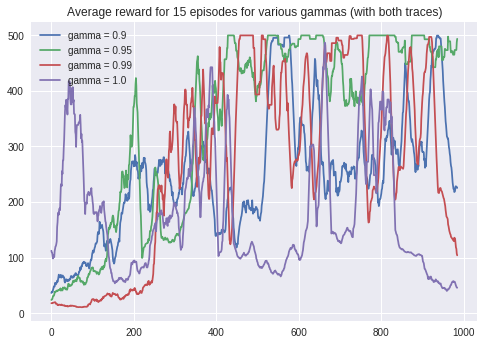

In [27]:
plt.title("Average reward for 15 episodes for various gammas (with both traces)")

for i in range(len(gammas)):
  plt.plot([np.mean(all_gamma_rewards[i][ix - 15: ix]) 
            for ix in range(15, len(all_gamma_rewards[i]))], 
           label = "gamma = "+str(gammas[i]))

plt.legend()
plt.show()

In [39]:
print("\n------------------------------------------------------")
print("            Effect of lambda (with both traces)" )
print("------------------------------------------------------")

all_lambda_rewards=[]
lambdas = [0.9, 0.95, 0.99, 1.]

ENV_NAME = 'CartPole-v1'
NB_EPISODES = 500
for lambd in lambdas:
  agent = Agent(ENV_NAME, gamma = gamma,
                policy_alpha= policy_alpha, critic_alpha= critic_alpha, 
                policy_lambda = lambd, critic_lambda = lambd,
                use_policy_trace=True, use_critic_trace=True)
  r = train_agent(agent, ENV_NAME, NB_EPISODES, plot_results=False)
  all_lambda_rewards.append(r)


------------------------------------------------------
            Effect of lambda (with both traces)
------------------------------------------------------
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
..........
..........
..........
..........
..........
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
..........
..........
..........
..........
..........
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
..........
..........
..........
..........
......

....
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
..........
..........
..........
..........
..........


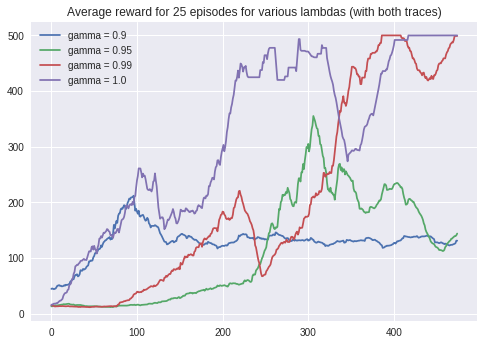

In [40]:
plt.title("Average reward for 25 episodes for various lambdas (with both traces)")

for i in range(len(lambdas)):
  plt.plot([np.mean(all_lambda_rewards[i][ix - 25: ix]) 
            for ix in range(25, len(all_lambda_rewards[i]))], 
           label = "gamma = "+str(lambdas[i]))

plt.legend()
plt.show()

# Discussion

The hyperparameters chosen were:
- $\gamma$ = 0.95
- $\alpha$ = 0.01 (for both $\alpha$)
- $\lambda$ = 0.99 (for both $\lambda$)

### With both traces
As we can see, the results with both traces was much better. Since the goal was to obtain 500 as reward (meaning that the pole didn't fall before the end of the game, which occurs at timestep 500), the policy gradient with both traces performed well after ~600 epochs of training. Sometimes, it does not behave optimally, even though it achieved the maximal reward a few steps before, but it quickly learn "back" what it has lost. The choice of hyperparameters needed to be careful in order to avoid a learning curve that "learns and forgets" very often.

### With 1 trace and without trace
Even though we only show the same hyperparameters than the optimal hyperparameters choosen for the 2-traces case, all the results found were similar : it didn't learn to stay alive (without the pole falling on the floor) more than ~120 time steps for any set of hyperparameters tested. We can thus see that the trace helps the training a lot.


### Effect of gamma
The $\gamma$ chosen was 0.95. As it gets higher than that, the average reward started oscillating a lot. It still got to high average reward (average on 15 episodes), but was followed by big drops. We wanted to avoid the "learning" followed by "forgetting" as much as we could.


### Effect of $\lambda$
As we can see, the results for lambda are better when using a high $\lambda$. It can learn better and avoid forgetting what it has learned.